In [1]:
%load_ext autoreload
%autoreload 2

import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

from torch_geometric.datasets import CoraFull, TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric import utils, nn as gnn, transforms as T
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
plt.style.use("seaborn-v0_8")

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mt_ds = TUDataset("/mnt/dl/datasets/gnn/tudataset/", name="MUTAG")

In [3]:
# mt_ds.x = T.NormalizeFeatures(["x"])(mt_ds)

In [4]:
loader = DataLoader(mt_ds, batch_size=16)

In [5]:
len(loader)

12

In [6]:
mt_ds.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [7]:
mt_ds[0].edge_index

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])

In [8]:
mt_ds.x.shape

torch.Size([3371, 7])

In [9]:
mt_ds.x[0]

tensor([1., 0., 0., 0., 0., 0., 0.])

In [10]:
data = next(iter(loader))

In [11]:
data

DataBatch(edge_index=[2, 620], x=[279, 7], edge_attr=[620, 4], y=[16], batch=[279], ptr=[17])

In [12]:
class GNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(7, 32)
        self.conv2 = GATConv(32, 48)
        self.conv3 = GATConv(48, 64)
        self.lin = nn.Linear(64, 1)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, 0.1)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, 0.1)
        
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)

        x = self.lin(x)
        return x

In [13]:
model = GNN().cuda()
adam = torch.optim.Adam(model.parameters(), 1e-4)
losses = []
for i in range(100):
    for j, data in enumerate(loader):
        data.cuda()
        yhat = model(data.x, data.edge_index, data.batch).squeeze()
        adam.zero_grad()
        loss = F.binary_cross_entropy_with_logits(yhat, 
                                                  data.y.float())
        loss.backward()
        adam.step()
        losses.append(loss.item())
    

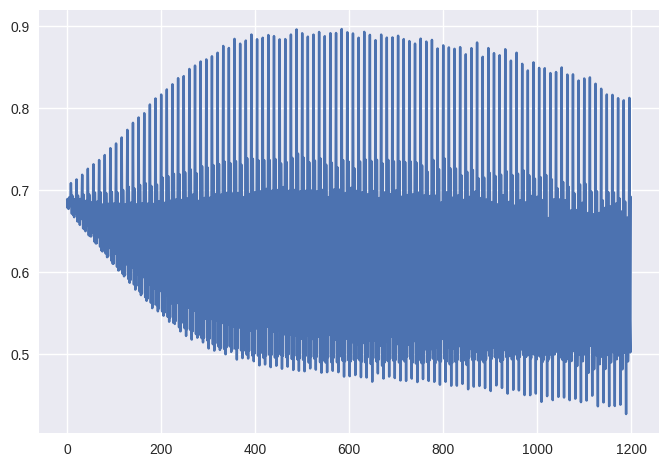

In [14]:
plt.plot(losses)